# Biodiversity

## Import modules

First we need to import the modules.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Read the data

In [2]:
observations = pd.read_csv('observations.csv')
species = pd.read_csv('species_info.csv')
print(observations.head())
print(species.head())
print(observations.info())
print(species.info())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic 

## Analyze the data

The first thing is to find the number of distinct species in the data. There are 5541 species.

In [3]:
print(f"number of species:{species['scientific_name'].nunique()}")

number of species:5541


Next is to find the number of category that are represented in the data and there are 5 animal categories and 2 plant categories.

In [4]:
print(f"number of categories:{species['category'].nunique()}")
print(f"categories:{species['category'].unique()}")

number of categories:7
categories:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


Another column to explore is conservation_status. The column has 4 categories

In [5]:
print(f"number of conservation statuses:{species['conservation_status'].nunique()}")
print(f"unique conservation statuses:{species['conservation_status'].unique()}")

number of conservation statuses:4
unique conservation statuses:[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


The absence of data here means that these species are not under any conservation status. So, let's fill the data with "N/A"

In [6]:
species['conservation_status'] = species['conservation_status'].fillna("N/A")
print(species.groupby("conservation_status").size())

conservation_status
Endangered              16
In Recovery              4
N/A                   5633
Species of Concern     161
Threatened              10
dtype: int64


Next is to checkout the different categories that are nested in the conservation_status column except for the ones that do not require an intervention.

In [7]:
# The Table
conservationCategory = species[species.conservation_status != "N/A"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


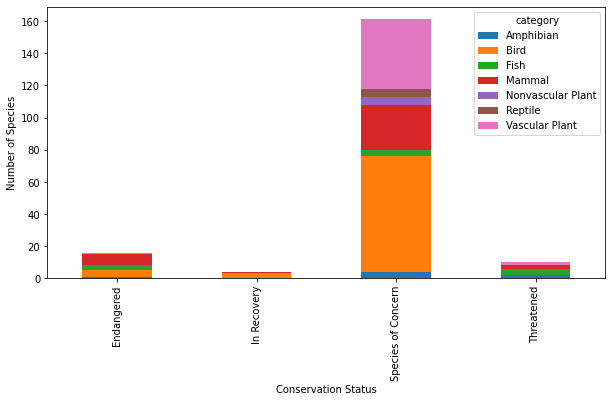

In [8]:
# The graph
ax = conservationCategory.plot(kind = 'bar', figsize=(10,5), 
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

Let's see now if certain types of species are more likely to be endangered. First we create a new column to separate the "N/A" species from the rest.

In [9]:
species['is_protected'] = species.conservation_status != 'N/A'

# Results
category_counts = species.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


Let's calculate the percentage of protected species for each specie

In [10]:
category_counts['percent_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


This section will run some chi-squared tests to see if different species have statistically significant differences in conservation status rates.
First we run the test with mammal and birds.

In [11]:
from scipy.stats import chi2_contingency

contingency1 = [[30, 146],
              [75, 413]]
chi2, pval, dof, expected = chi2_contingency(contingency1)
if pval < 0.05:
    print("the difference is significative")
else:
    print("there is no significative difference")
expected

there is no significative difference


array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]])

Now let's do de same with mammal and reptile.

In [12]:
contingency2 = [[30, 146],
               [5, 73]]
chi2, pval, dof, expected = chi2_contingency(contingency2)
if pval < 0.05:
    print("the difference is significative")
else:
    print("there is no significative difference")
expected

the difference is significative


array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]])

The next set of analysis will come from data from the conservationists as they have been recording sightings of different species at several national parks.

The first step is to look at the the common names from species to get an idea of the most prevalent animals in the dataset. The data will be need to be split up into individual names.

In [13]:
from itertools import chain
import string

# Split up the data into individual names
# Delete punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

# Clean up duplicated words in the same row
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
# Collapse in the same list
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
print(res[:10])

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated']


Now the data is ready to be able to count the number of occurrences of each word.

In [14]:
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
148,Bat,23
88,Shrew,18
99,Myotis,17
33,Mouse,16
37,Chipmunk,13
72,Squirrel,12
5,American,12
131,Vole,11
135,Eastern,11
151,Mountain,10


Let's create a new row to check if the specie is a Myotis

In [15]:
species['is_myotis'] = species.common_names.str.contains(r"\bMyotis\b", regex = True)
species[species.is_myotis]

,category,scientific_name,common_names,conservation_status,is_protected,is_myotis
33,Mammal,Myotis austroriparius,"Mississippi Myotis, Southeastern Myotis",Species of Concern,True,True
34,Mammal,Myotis grisescens,Gray Myotis,Endangered,True,True
35,Mammal,Myotis keenii,Keen's Myotis,Species of Concern,True,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
3039,Mammal,Myotis californicus,"California Myotis, California Myotis, Californ...",Species of Concern,True,True
3040,Mammal,Myotis ciliolabrum,"Small-Footed Myotis, Western Small-Footed Bat,...",N/A,False,True
3041,Mammal,Myotis evotis,"Long-Eared Myotis, Long-Eared Myotis",Species of Concern,True,True


Next the results of the myotis species will be merged with observations to create a DataFrame with observations of myotis across the national parks.

In [16]:
myotis_observations = observations.merge(species[species.is_myotis])
myotis_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,2566
1,Great Smoky Mountains National Park,1635
2,Yellowstone National Park,5790
3,Yosemite National Park,3387


Now let's see each park broken down by protected vs. non-protected sightings.

In [17]:
obs_by_park = myotis_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,402
1,Bryce National Park,True,2164
2,Great Smoky Mountains National Park,False,316
3,Great Smoky Mountains National Park,True,1319
4,Yellowstone National Park,False,1016
5,Yellowstone National Park,True,4774
6,Yosemite National Park,False,516
7,Yosemite National Park,True,2871


Let's plot this result

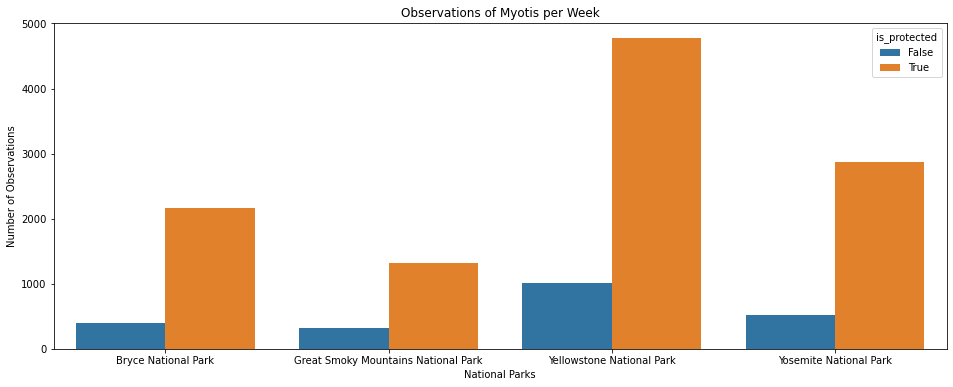

In [18]:
plt.figure(figsize=(16, 6))
sns.barplot(x=obs_by_park.park_name, y= obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Myotis per Week')
plt.show()

## Conclusions

The project was able to make several data visualizations and inferences about the various species in four of the National Parks that comprised this data set.


- The vast majority of species were not part of conservation.(5,633 vs 191)
- Mammals and Birds had the highest percentage of being in protection.
- While mammals and Birds did not have significant difference in conservation percentage, mammals and reptiles exhibited a statistically significant difference.
- The study found that bats occurred the most number of times.
